## Part 1 - Solving TSP Using Search Heuristics



In this part we will use three search heuristic to find an approximate solution of the Travelling Salesman Problem (TSP), which is NP-hard. In TSP, we are given a non-negative zero-diagonal symmetric matrix which models a fully connected graph - the nodes are locations, and edge weight between the two nodes is a cost of travelling from one node to the other. Our goal with TSP is to find a way for our Salesman to visit each node once (and only once) before returning to the starting node, while minimizing the cost of doing so.

Here we will deal with the 'general TSP', meaning that we will be using randomly generated matrices to model the fully connected graphs with weighted edges that the Salesman needs to traverse. The randomly generated matrices won't represent real world locations and distances between them, as the distances won't necessarily satisfy triangle inequalities, and won't make geometrical sense. The TSP where distances, i.e. the edge weights of the graph do satisfy triangle inequalities, and correspond to geometrical distances is called Euclidean TSP.

However, as we are not solving the Euclidean TSP here, we can interpret the edge weights of the TSP graph as an (abstract) cost for the Salesman to go from one edge to the other. Worth mentioning is that we will always use the node labeled 0 as the starting (and ending point) of the route. Also, our weights will take random values from in the interval [1,100].

We first make some necessary imports, and set the seed for randomization. Then we give some helper functions.

In [1]:
import numpy as np
import pandas as pd
import timeit
import time
import random
import matplotlib.pyplot as plt
from functools import partial
np.random.seed(513)

In [2]:
def generate_rand_tsp_matrix_family(dim, size=30):
    
    '''Generates a family of TSP matrices of a given dimension. Each matrix
    modells a TSP graph, where the entries represent edge weights, i.e. 
    the cost of travelling from one node to the other.'''
    
    matrix_family = []
    for _ in range(size):
        A = np.random.randint(1, 101, size=(dim,dim))
        A_tsp = np.tril(A, -1) + np.tril(A, -1).T
        matrix_family.append(A_tsp)
        
    return matrix_family

Now we will create a family of matrices of varying dimensions on which we'll run our experiments.

In [4]:
dims = dims = [5, 10, 15, 20, 25, 50, 75]
matrix_families = []
for dim in dims:
    matrix_family = generate_rand_tsp_matrix_family(dim)
    matrix_families.append(matrix_family)

#some examples of matrices:
for i in range(3):
    print(matrix_families[0][i])
    print('----------------------')

[[ 0 50 62 17 82]
 [50  0 54 39 60]
 [62 54  0 25 18]
 [17 39 25  0  4]
 [82 60 18  4  0]]
----------------------
[[ 0 43 87 93 53]
 [43  0 85  1 68]
 [87 85  0 76 99]
 [93  1 76  0 51]
 [53 68 99 51  0]]
----------------------
[[ 0 86 92 46 95]
 [86  0 42 29 83]
 [92 42  0 35 57]
 [46 29 35  0 54]
 [95 83 57 54  0]]
----------------------


In [5]:
def calc_stats(routes_costs):
    
    '''Calculates minimal, average and maximal route cost from a given set
    of solutions.'''
    
    min_route_cost = np.min(routes_costs)
    avg_route_cost = np.round(np.mean(routes_costs), 2)
    max_route_cost = np.max(routes_costs)
    
    print(f'MIN: {min_route_cost}, AVG: {avg_route_cost}, MAX: {max_route_cost}')
    return min_route_cost, avg_route_cost, max_route_cost

In [6]:
def compute_and_time_it(tsp_matrices, alg):
    
    '''Finds a set of TSP solutions for a given algorithm and a family of matrices,
    and outputs the total real world/CPU computing time for finding all the solutions.'''
    
    
    t_rw0 = timeit.default_timer()
    t_cpu0 = time.process_time()
    
    results = [alg(A)[1] for A in tsp_matrices]
    
    t_cpu = time.process_time() - t_cpu0
    t_rw = timeit.default_timer() - t_rw0
    
    
    t_rw = np.round(t_rw/60, 4)
    t_cpu = np.round(t_cpu/60, 4)
    
    print(f'Total real-world running time: {t_rw}min')
    print(f'Total CPU running time: {t_cpu}min')
    
    return results, t_rw, t_cpu

In [7]:
def calc_total_cost(A, route):
    
    '''Computes the cost of a given route.'''
    
    total_cost = 0
    for i in range(len(route)-1):
        total_cost += A[route[i], route[i+1]]
    return total_cost

### Nearest Neghbours (NN)

This is a greedy algorithm in which the Salesman makes his route by going to the unvisited node by picking the edge with the lowest traveliing cost among all the available edges, returning to the starting node, after he has visited all the nodes.

In [8]:
def A_NN(A):
    
    route = [0]
    unvisited_nodes = list(range(1, dim))
    mask = np.zeros(dim)
    mask[0] = 1
    
    current_node = 0
    
    while len(unvisited_nodes) > 1:
        weights = np.ma.array(A[current_node], mask=mask)
        nearest_node = np.argmin(weights)
        current_node = nearest_node
        route.append(current_node)
        unvisited_nodes.remove(current_node)
        mask[current_node] = 1
        
    last_node = unvisited_nodes.pop()
    route.append(last_node)
    route.append(0)
    
    total_cost = calc_total_cost(A, route)
        
    return route, total_cost

### NN with 2-opt (NN2O)

This is a deterministic algorithm which starts from a suboptimal NN solution, and tries to further optimize it by reducing the total cost. Given the starting configuration it iterates through the pair of disjoint edges $A-B$ and $C-D$, 'rewires' the edges between the respective nodes (so that in the new configuration we have $A-C$ and $B-D$), and then computes the total cost for the new configuration. If the cost is lower, it starts iterating again on this new configuration. If after iterating through all the paires of edges no improvement has been made, the algorithm stops. 

In [9]:
def opt_2(A, route, best_cost):
     
    while True:
        for i in range(1, dim-1):
            for j in range(i + 1, dim):
                new_route = route[:i] + [*reversed(route[i:j + 1])] + route[j + 1:]
                new_cost = calc_total_cost(A, new_route)

                if new_cost < best_cost:
                    break

            if new_cost < best_cost:
                route = new_route
                best_cost = new_cost
                break

        else:
            break
    
    return route, best_cost

In [10]:
def A_NN2O(A):
    start_route, start_cost = A_NN(A)
    route, best_cost = opt_2(A, start_route, start_cost)
    return route, best_cost

### Repeated Randomized NN

This is a stochastic version of NN algorithm, where the Salesman picks the next edge at random from $n$ available edges with the lowest cost. By default, we set $n = 3$.

In [11]:
def repeated_randomized_NN(A, n=3):
    
    route = [0]
    unvisited_nodes = list(range(1, dim))
    mask = np.zeros(dim)
    mask[0] = 1
    
    current_node = 0
    
    while len(unvisited_nodes) > 1:
        weights = np.ma.array(A[current_node], mask=mask)        
        nearest_nodes = np.argsort(weights)[:min(n, len(unvisited_nodes))]
        current_node = np.random.choice(nearest_nodes)
        route.append(current_node)
        unvisited_nodes.remove(current_node)
        mask[current_node] = 1
        
    last_node = unvisited_nodes.pop()
    route.append(last_node)
    route.append(0)
    
    total_cost = calc_total_cost(A, route)
    
    
    return route, total_cost

### Repeated Randomized NN with 2-opt (RNN)

This algorithm first builds a suboptimal solution by running the repeated randomized NN. Then, it utilizes NN2O to further improve upon the selected solution. It repeats this procedure $m$ times and then selects the best solution out of those. By default, we set $m = 7$.

In [12]:
def A_RNN(A, n=3, num_tries=7):
    best_route = []
    best_cost = np.inf
    
    for _ in range(num_tries):
        start_route, start_cost = repeated_randomized_NN(A, n)
        route, cost = opt_2(A, start_route, start_cost)
        
        if cost < best_cost:
            best_route = route
            best_cost = cost
        
    return best_route, best_cost

### Comparing the algorithms

Now we compare NN, NN2O and RNN algorithms. We randomly generate a family of 30 TSP matrices and run these algorithms on each one, trying these algorithms for matrices of different dimensions. We are interested in minimal/maximal and average cost for the given family of matrices, as well as in measuring the total execution time for an algorithm to go through the whole family of 30 matrices. 

In [13]:
dims = [5, 10, 15, 20, 25, 50, 75]
complete_stats = []
complete_runtimes = []
for i, dim in enumerate(dims):
    print('dim:', dim)
    print('-------------------------------')
    stats = [dim]
    runtimes = [dim]
    tsp_matrices = matrix_families[i]
    
    print('NN:')
    nn = compute_and_time_it(tsp_matrices, A_NN)
    stats.extend(calc_stats(nn[0]))
    runtimes.extend(nn[1:])
    print('\n')
    
    
    print('NN2O:')
    nn2o = compute_and_time_it(tsp_matrices, A_NN2O)
    stats.extend(calc_stats(nn2o[0]))
    runtimes.extend(nn2o[1:])
    print('\n')
    
   
    print('RNN:')
    rnn = compute_and_time_it(tsp_matrices, A_RNN)
    stats.extend(calc_stats(rnn[0]))
    runtimes.extend(rnn[1:])
    
    
    complete_stats.append(stats)
    complete_runtimes.append(runtimes)
    print('-------------------------------')

dim: 5
-------------------------------
NN:
Total real-world running time: 0.0002min
Total CPU running time: 0.0008min
MIN: 114, AVG: 194.2, MAX: 291


NN2O:
Total real-world running time: 0.0001min
Total CPU running time: 0.0min
MIN: 97, AVG: 185.73, MAX: 277


RNN:
Total real-world running time: 0.0013min
Total CPU running time: 0.001min
MIN: 97, AVG: 184.83, MAX: 273
-------------------------------
dim: 10
-------------------------------
NN:
Total real-world running time: 0.0002min
Total CPU running time: 0.0003min
MIN: 138, AVG: 248.3, MAX: 370


NN2O:
Total real-world running time: 0.0004min
Total CPU running time: 0.0005min
MIN: 123, AVG: 202.97, MAX: 331


RNN:
Total real-world running time: 0.0044min
Total CPU running time: 0.0042min
MIN: 113, AVG: 193.7, MAX: 316
-------------------------------
dim: 15
-------------------------------
NN:
Total real-world running time: 0.0003min
Total CPU running time: 0.0003min
MIN: 190, AVG: 291.07, MAX: 381


NN2O:
Total real-world running ti

The graph below shows the comparison of the solutions regarding the cost.

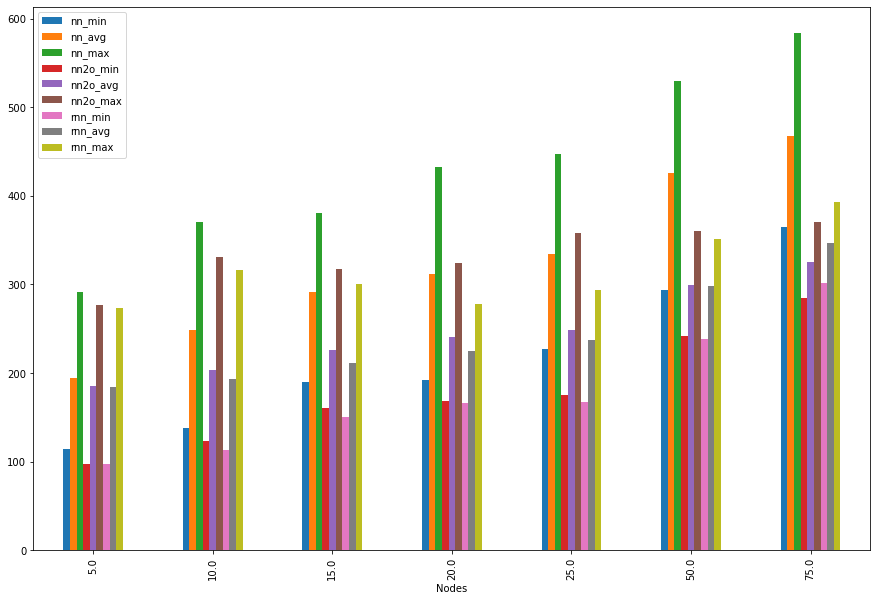

In [15]:
%matplotlib inline
data = np.array(complete_stats)

columns = ['Nodes',
          'nn_min', 'nn_avg', 'nn_max',
          'nn2o_min', 'nn2o_avg', 'nn2o_max',
          'rnn_min', 'rnn_avg', 'rnn_max']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(15,10))
plt.show()

Consulting the graph we can conclude that as number of nodes increases NN2O and RNN manage to make substantial improvements over NN solutions. Comparing NN2O with RNN, we see that they perform similarly on average, with RNN outpeforming NN2O by some ammount. 

However, we may also notice that, as the dimension increases, they give almost equal performance, and as it seems NN2O starts to outperform RNN for higher dimensions. This hypothesis can make sense - as the dimension increases, so the space of starting solutions of randomized NN increases, so that selecting between deterministic greedy NN starting solution and stochastic NN solution makes almost no difference, with the greedy NN solution maybe even being the best option to start from.

Now we compare the execution time of those algorithms.

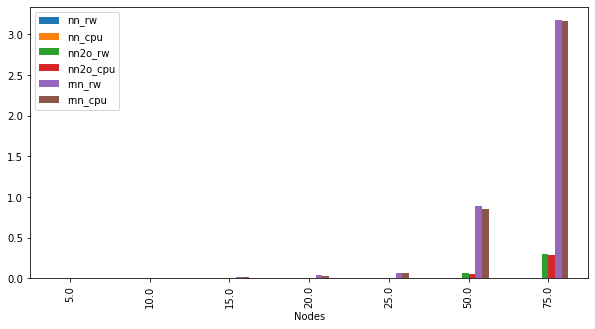

In [17]:
%matplotlib inline
data = np.array(complete_runtimes)

columns = ['Nodes',
          'nn_rw', 'nn_cpu',
          'nn2o_rw', 'nn2o_cpu',
          'rnn_rw', 'rnn_cpu']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(10,5))
plt.show()

From this graph we see that NN executes almost instantly even for higher dimensions. Unfortunately, it produces quite bad approximative solution, compared to NN2O and RNN. Considering NN2O, we see that its execution time starts to be noticeable for higher dimensions, although it still executes quite fast. As for RNN we can even see the exponential rise in computation time as the dimension increases.

Having in midn, the performance of NN2O and RNN regarding the total cost, we can conclude that it is better to use NN2O for higer dimensions, as it outputs the solution with the average cost similar (if not better!) to RNN, as the dimension increases.

As for the real world vs. CPU running time there is just a small difference, which might get bigger for higher dimensions.

### Testing RNN for various n

Now we test RNN while varying the number of $n$ lowest cost edges for randomised NN algorithm to chose from. For a comparison, we also output the results for NN2O algorithm for the same given family of matrices.

In [18]:
dims = [5, 10, 15, 20, 25, 50, 75]
exp1_stats = []
exp1_runtimes = []
for i, dim in enumerate(dims):
    print('dim:', dim)
    print('-------------------------------')
    stats = [dim]
    runtimes = [dim]
    tsp_matrices = matrix_families[i]
    nn2o_e
    xp1 = compute_and_time_it(tsp_matrices, A_NN2O)
    print('NN2O:')
    stats.append(calc_stats(nn2o_exp1[0])[1])
    runtimes.extend(nn2o_exp1[1:])
    print('\n')
    
    for n in [2, 3, 7, 15]:
        print('n =', n)
        rnn2o_exp1 = compute_and_time_it(tsp_matrices, partial(A_RNN, n=n))
        print('RNN:',)
        stats.append(calc_stats(rnn2o_exp1[0])[1])
        runtimes.extend(rnn2o_exp1[1:])
        print('------------------------------')
    exp1_stats.append(stats)
    exp1_runtimes.append(runtimes)
    print('------------------------------')

dim: 5
-------------------------------
Total real-world running time: 0.0002min
Total CPU running time: 0.0003min
NN2O:
MIN: 97, AVG: 185.73, MAX: 277


n = 2
Total real-world running time: 0.0011min
Total CPU running time: 0.001min
RNN:
MIN: 97, AVG: 185.0, MAX: 277
------------------------------
n = 3
Total real-world running time: 0.001min
Total CPU running time: 0.001min
RNN:
MIN: 97, AVG: 185.03, MAX: 273
------------------------------
n = 7
Total real-world running time: 0.001min
Total CPU running time: 0.0008min
RNN:
MIN: 97, AVG: 184.83, MAX: 273
------------------------------
n = 15
Total real-world running time: 0.0011min
Total CPU running time: 0.001min
RNN:
MIN: 97, AVG: 184.83, MAX: 273
------------------------------
------------------------------
dim: 10
-------------------------------
Total real-world running time: 0.0004min
Total CPU running time: 0.0003min
NN2O:
MIN: 123, AVG: 202.97, MAX: 331


n = 2
Total real-world running time: 0.0042min
Total CPU running time: 0.0

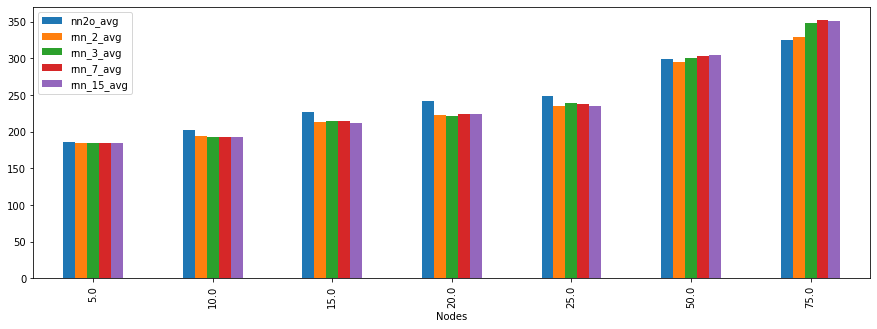

In [19]:
%matplotlib inline
data = np.array(exp1_stats)

columns = ['Nodes', 'nn2o_avg', 'rnn_2_avg', 'rnn_3_avg', 'rnn_7_avg', 'rnn_15_avg']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(15, 5))
plt.show()

Here we can also notice how NN2O overtakes RNN regarding the cost-effectivness, as the dimension increases. As for varying $n$ for RNN, for smaller dimension, the selection of $n$ makes little to no difference. As for the higher dimensions selecting too big $n$ might not be the best choice, as it gives the Salesman option to chose some very cost expensive alternatives, which don't produce much improved solution than the greedy NN, even in the long run.

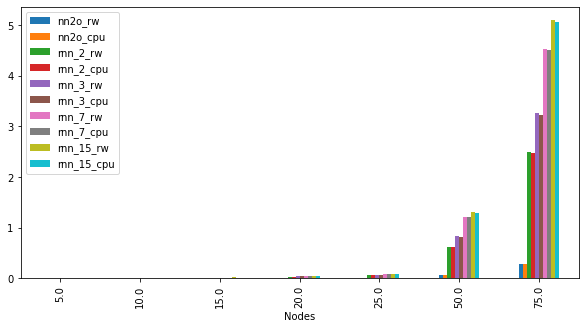

In [20]:
%matplotlib inline
data = np.array(exp1_runtimes)

columns = ['Nodes',
          'nn2o_rw', 'nn2o_cpu',
          'rnn_2_rw', 'rnn_2_cpu',
          'rnn_3_rw', 'rnn_3_cpu',
          'rnn_7_rw', 'rnn_7_cpu',
          'rnn_15_rw', 'rnn_15_cpu']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(10,5))
plt.show()

We also notice an exponential increase in execution time for RNN as the dimension increases. Also, for higher dimensions, we there is a noticable rise in running time as $n$ increases. Maybe introducing to much randomness can give a pretty bad starting solution for RNN, so it need more time trying to make it more optimal. 

### NN with 3-opt (NN3O)

This algorithm works in similar fashion as NN with 2-opt, but here we are iterating through the triplets of edges and 'rewiring' them in different way, in order to produce an improved solution. 2-opt solutions actually make a subset of 3-opt solutions. Although the following code tries searching through 'strict' 3-opt solutions, sometimes they can degenerate into 2-opt solutions.

Here we compare NN with 3-opt vs. NN with 2-opt.

In [21]:
def A_NN3O(A):
    r, best_cost = A_NN(A)
    
    while True:
        for i in range(1, dim - 3):
            for j in range(i + 1, dim - 2):
                for k in range(j + 2, dim):
                    l1 = r[:i] + r[j:i-1:-1] + r[k:j:-1] + r[k+1:]
                    l2 = r[:i] + r[j+1:k+1] + r[i:j+1] + r[k+1:]
                    l3 = r[:i] + r[j+1:k+1] + r[j:i-1:-1] + r[k+1:]
                    l4 = r[:i] + r[k:j:-1] + r[i:j+1] + r[k+1:]
                    for new_route in [l1, l2, l3, l4]:
                        new_cost = calc_total_cost(A, new_route)
                        if new_cost < best_cost:
                            break
                    if new_cost < best_cost:
                        break
                if new_cost < best_cost:
                    break
            if new_cost < best_cost:
                r = new_route
                best_cost = new_cost
                break
        else:
            break
                
    return r, best_cost

In [22]:
dims = [5, 10, 15, 20, 25, 50]
exp2_stats = []
exp2_runtimes = []
for i, dim in enumerate(dims):
    print('dim:', dim)
    print('------------------------------')
    stats = [dim]
    runtimes = [dim]
    tsp_matrices = matrix_families[i]
    
    nn2o_exp2 = compute_and_time_it(tsp_matrices, A_NN2O)
    print('NN2O:')
    stats.append(calc_stats(nn2o_exp2[0])[1])
    runtimes.extend(nn2o_exp2[1:])
    print('\n')
    
    print('NN3O:')
    nn3o_exp2 = compute_and_time_it(tsp_matrices, A_NN3O)
    stats.append(calc_stats(nn3o_exp2[0])[1])
    runtimes.extend(nn3o_exp2[1:])
    print('\n')
    
    exp2_stats.append(stats)
    exp2_runtimes.append(runtimes)
    print('------------------------------')

dim: 5
------------------------------
Total real-world running time: 0.0002min
Total CPU running time: 0.0003min
NN2O:
MIN: 97, AVG: 185.73, MAX: 277


NN3O:
Total real-world running time: 0.0002min
Total CPU running time: 0.0003min
MIN: 114, AVG: 191.57, MAX: 273


------------------------------
dim: 10
------------------------------
Total real-world running time: 0.0007min
Total CPU running time: 0.0008min
NN2O:
MIN: 123, AVG: 202.97, MAX: 331


NN3O:
Total real-world running time: 0.0022min
Total CPU running time: 0.0023min
MIN: 118, AVG: 196.17, MAX: 316


------------------------------
dim: 15
------------------------------
Total real-world running time: 0.0018min
Total CPU running time: 0.0021min
NN2O:
MIN: 161, AVG: 226.57, MAX: 318


NN3O:
Total real-world running time: 0.0126min
Total CPU running time: 0.0122min
MIN: 147, AVG: 214.3, MAX: 301


------------------------------
dim: 20
------------------------------
Total real-world running time: 0.0041min
Total CPU running time:

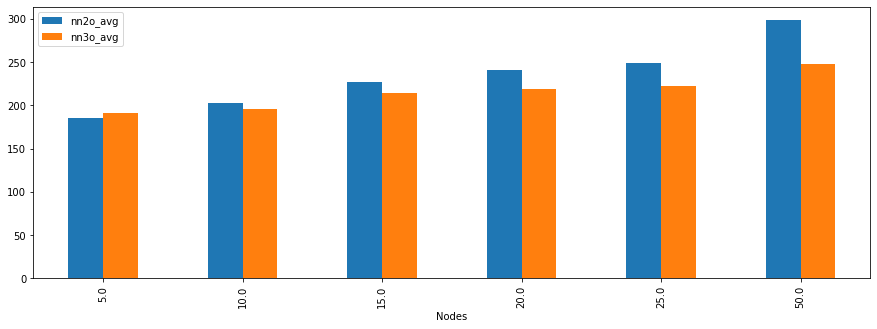

In [23]:
%matplotlib inline
data = np.array(exp2_stats)

columns = ['Nodes', 'nn2o_avg', 'nn3o_avg']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(15, 5))
plt.show()

From the graph above, we can see that NN3O almost always outperforms NN2O regarding the average cost, which is especially noticeable for higher dimensions.

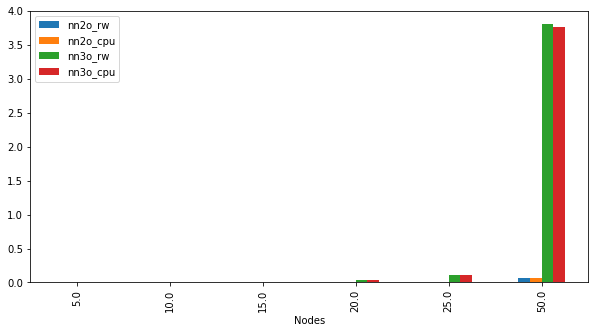

In [24]:
%matplotlib inline
data = np.array(exp2_runtimes)

columns = ['Nodes',
          'nn2o_rw', 'nn2o_cpu',
          'nn3o_rw', 'nn3o_cpu']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(10,5))
plt.show()

And here are the bad news - even though NN3O outputs better solutions than NN2O for higher dimensions, it becamomes terribly cost ineffective for higher dimensions. 

### Varying number of tries for RNN

We are also curious to see how changing the number $m$ of stochastic solutions for RNN to chose from affects the results. To see this, we run RNN on the same family of matrices, while varying $m$. For comparison, we also run NN2O on the same family of matrices.

In [31]:
dims = [5, 10, 15, 20, 25, 50, 75]
exp3_stats = []
exp3_runtimes = []
for i, dim in enumerate(dims):
    print('dim:', dim)
    print('------------------------------')
    stats = [dim]
    runtimes = [dim]
    tsp_matrices = matrix_families[i]
    nn2o_exp3 = compute_and_time_it(tsp_matrices, A_NN2O)
    print('NN2O:')
    stats.append(calc_stats(nn2o_exp3[0])[1])
    runtimes.extend(nn2o_exp3[1:])
    print('\n')
    
    for m in [3, 7, 15]:
        print('m =', m)
        rnn2o_exp3 = compute_and_time_it(tsp_matrices, partial(A_RNN, num_tries=m))
        print('RNN:',)
        stats.append(calc_stats(rnn2o_exp3[0])[1])
        runtimes.extend(rnn2o_exp3[1:])
        print('------------------------------')
    exp3_stats.append(stats)
    exp3_runtimes.append(runtimes)
    print('------------------------------')

dim: 5
------------------------------
Total real-world running time: 0.0002min
Total CPU running time: 0.0min
NN2O:
MIN: 97, AVG: 185.73, MAX: 277


m = 3
Total real-world running time: 0.0005min
Total CPU running time: 0.0008min
RNN:
MIN: 97, AVG: 184.83, MAX: 273
------------------------------
m = 7
Total real-world running time: 0.0011min
Total CPU running time: 0.0013min
RNN:
MIN: 97, AVG: 185.0, MAX: 273
------------------------------
m = 15
Total real-world running time: 0.0018min
Total CPU running time: 0.0018min
RNN:
MIN: 97, AVG: 184.83, MAX: 273
------------------------------
------------------------------
dim: 10
------------------------------
Total real-world running time: 0.0005min
Total CPU running time: 0.0005min
NN2O:
MIN: 123, AVG: 202.97, MAX: 331


m = 3
Total real-world running time: 0.0019min
Total CPU running time: 0.0021min
RNN:
MIN: 113, AVG: 194.23, MAX: 322
------------------------------
m = 7
Total real-world running time: 0.0045min
Total CPU running time: 0.

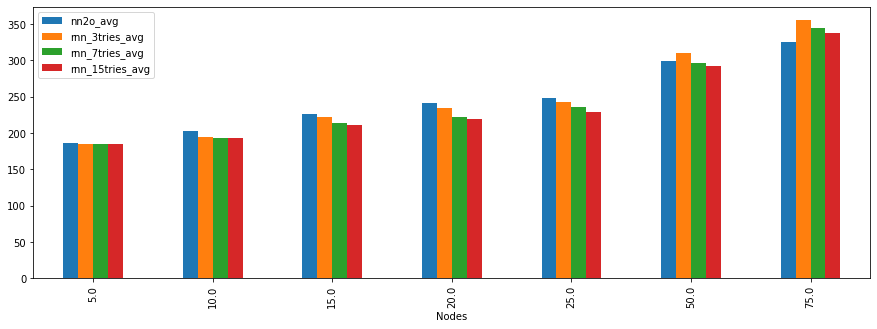

In [33]:
%matplotlib inline
data = np.array(exp3_stats)

columns = ['Nodes', 'nn2o_avg', 'rnn_3tries_avg', 'rnn_7tries_avg', 'rnn_15tries_avg']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(15, 5))
plt.show()

We can observe that for smaller dimensions increasing number of tries brings some improvement. However, for higher dimension NN2O is still a better option, unless we are willing to try a large amount of tries for RNN, which, from the graph below can prove quite ineffective regarding the execution time. 

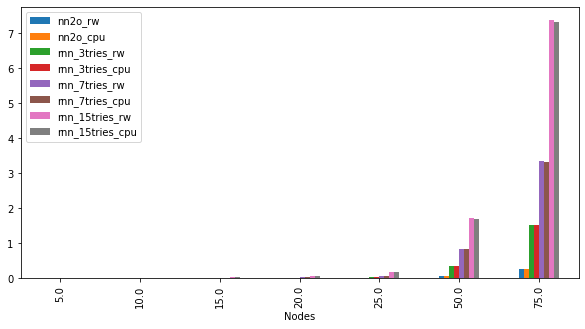

In [34]:
%matplotlib inline
data = np.array(exp3_runtimes)

columns = ['Nodes',
          'nn2o_rw', 'nn2o_cpu',
          'rnn_3tries_rw', 'rnn_3tries_cpu',
          'rnn_7tries_rw', 'rnn_7tries_cpu',
          'rnn_15tries_rw', 'rnn_15tries_cpu']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(10,5))
plt.show()

### Part 1 Conclusion

Given the data, we can conclude that for smaller dimensions NN3O is a good option to find the best cost effective approximate solution of TSP in a short time. However, for higher dimensions NN2O might be our best option, both regarding the cost and execution time. 

## Part 2 - Solving TSP with A* and MST Heuristic

In this part we'll try to approximate TSP solution using a Minimum Spanning Tree (MST) heuristic. Since TSP is essentially a spanning tree, its cost should be at least that of the MST. We can use this fact to try and find a good TSP solution with a cost that shouldn't differ so much from the cost of MST.

We'll utilise Prim's algorithm for computing the MST. This is a greedy algorithm which grows MST one edge per iteration, starting from the starting edge, adding the edge with the lowest cost from the visited ones, in every iteration.

First we introduce some helper functions.

In [35]:
def calculate_mst_cost(A, mst):
    
    '''Computes the cost of a given MST.'''
    
    mst_cost = 0
    for edge in mst:
        mst_cost += A[edge[0], edge[1]]
    return mst_cost

In [66]:
def prim_MST(A, route):
    
    '''Prim's algorithm for computing the MST.'''
    
    mask = np.zeros(dim)
    mask[route] = 1
    
    min_spanning_tree = []  
    unvisited_nodes = list(set(range(dim)) - set(route))
    visited_nodes = [route[-1]]
    
    while len(unvisited_nodes) > 0:
        
        new_edge = (None, None)
        best_edge_cost = np.infty
        
        for start_node in visited_nodes:

            weights = np.ma.array(A[start_node], mask=mask)
            end_node = np.argmin(weights)
            new_edge_cost = A[start_node, end_node]
            
            if  new_edge_cost < best_edge_cost:
                new_edge = (start_node, end_node)
                best_edge_cost = new_edge_cost
                
        
        new_node = new_edge[1]
        mask[new_node] = 1
        visited_nodes.append(new_node)
        unvisited_nodes.remove(new_node)
        
        min_spanning_tree.append(new_edge)
        
    mst_cost = calculate_mst_cost(A, min_spanning_tree)
    
    return min_spanning_tree, mst_cost

A* algorithm for TSP works by building a route, starting from the initial node, and then computes a *successor function* $f(n)$ value for every node candidate $n$, choosing the new node so that $f(n)$ is minimized. 

The formula for $f(n)$ is given by
$$f(n) = g(n) + h(n),$$
where $g(n)$ is the *edge cost* and h(n) a heuristic which is used alongside with A*. 

In our case $g(n)$ will be computed by calculating the cost of the route already constructed, plus the lowest cost of the return edge from the starting node to the final node.

In [81]:
def successor_func(A, route):    
    mask = np.zeros(dim)
    mask[route] = 1
    final_edge_cost = np.ma.array(A[0], mask=mask).min()
    
    gn = calc_total_cost(A, route) + final_edge_cost
    hn = prim_MST(A, route)
    fn = gn + hn[1]
    return gn + hn[1]

In [82]:
def A_star(A):
    
    visited_nodes = []
    unvisited_nodes = list(range(dim))
    
    while len(unvisited_nodes) > 1:
        new_node = None
        fn = np.inf
        for new_node_candidate in unvisited_nodes:
            route_candidate = visited_nodes.copy()
            route_candidate.append(new_node_candidate)
            new_fn = successor_func(A, route_candidate)
            if new_fn < fn:
                new_node = new_node_candidate
                fn = new_fn
        visited_nodes.append(new_node)
        unvisited_nodes.remove(new_node)
    
    last_node = unvisited_nodes.pop()
    visited_nodes.append(last_node)
    final_route = visited_nodes + [0]
    total_cost = calc_total_cost(A, final_route)
    return final_route, total_cost        

In [94]:
dims = [5, 10, 15, 20, 25]
complete_stats1 = []
complete_runtimes1 = []
for i, dim in enumerate(dims):
    print('dim:', dim)
    print('-------------------------------')
    stats = [dim]
    runtimes = [dim]
    tsp_matrices = matrix_families[i]
    
    print('A*:')
    a_star = compute_and_time_it(tsp_matrices, A_star)
    stats.extend(calc_stats(a_star[0]))
    runtimes.extend(a_star[1:])
    print('\n')
    
    print('NN:')
    stats.extend(calc_stats(nn[0]))
    runtimes.extend(nn[1:])
    print('\n')
    
    
    print('NN2O:')
    stats.extend(calc_stats(nn2o[0]))
    runtimes.extend(nn2o[1:])
    print('\n')
    
    
    complete_stats1.append(stats)
    complete_runtimes1.append(runtimes)
    print('-------------------------------')

dim: 5
-------------------------------
A*:
Total real-world running time: 0.0027min
Total CPU running time: 0.0029min
MIN: 16, AVG: 159.27, MAX: 265


NN:
MIN: 365, AVG: 467.9, MAX: 584


NN2O:
MIN: 285, AVG: 325.27, MAX: 371


-------------------------------
dim: 10
-------------------------------
A*:
Total real-world running time: 0.0257min
Total CPU running time: 0.0258min
MIN: 111, AVG: 215.3, MAX: 324


NN:
MIN: 365, AVG: 467.9, MAX: 584


NN2O:
MIN: 285, AVG: 325.27, MAX: 371


-------------------------------
dim: 15
-------------------------------
A*:
Total real-world running time: 0.1152min
Total CPU running time: 0.1146min
MIN: 151, AVG: 275.97, MAX: 378


NN:
MIN: 365, AVG: 467.9, MAX: 584


NN2O:
MIN: 285, AVG: 325.27, MAX: 371


-------------------------------
dim: 20
-------------------------------
A*:
Total real-world running time: 0.338min
Total CPU running time: 0.337min
MIN: 185, AVG: 307.6, MAX: 433


NN:
MIN: 365, AVG: 467.9, MAX: 584


NN2O:
MIN: 285, AVG: 325.27, M

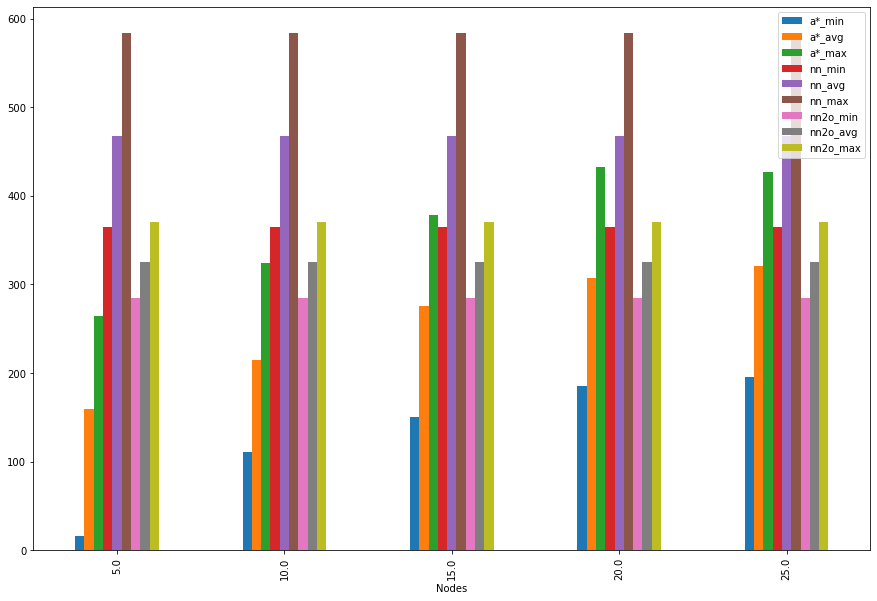

In [96]:
%matplotlib inline
data = np.array(complete_stats1)

columns = ['Nodes',
          'a*_min', 'a*_avg', 'a*_max',
          'nn_min', 'nn_avg', 'nn_max',
          'nn2o_min', 'nn2o_avg', 'nn2o_max',
          ]

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(15,10))
plt.show()

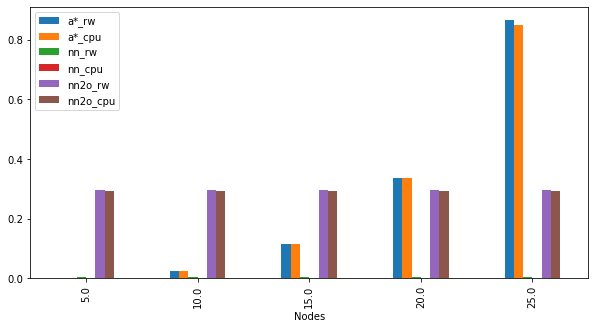

In [99]:
%matplotlib inline
data = np.array(complete_runtimes1)

columns = ['Nodes',
          'a*_rw', 'a*_cpu',
          'nn_rw', 'nn_cpu',
          'nn2o_rw', 'nn2o_cpu',
          ]

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(10,5))
plt.show()

Observing the two graphs from above, we can conclude that A* with MST heuristic gives solution far better than any of the previous algorithms. However, this comes with a price - already at dimension of 15 its execution time starts rising very rapidly. So, it might be best to use A* and MST only for smaller graphs.

## Part 3 - Exploring Local Search Algorithms

In this part we will try out three local search algorithms to find a good approximation of TSP problem.

### Hill-climbing algorithm

This is a stochastic algorithm which starts from a random route, and performs a local search in the 'neighborhood' of this route, on the space of all solutions. In our case, we'll obtain this 'close' route by swapping the order of two nodes in a given route.


Hill-climbingi s a rather fast algorithm with a drawback, that it can get stuck in a local minimum, which is far from the global minimum, thus providing a bad solution. This can be remedied by setting a maximal number of iterations for searching the neighborhood for improved local solution, before restarting the whole procedure, and randomly choosing a new initial solution. After a number of restart, the produced solutions are compared, and the one with the lowest cost is selected.

In [100]:
def node_swap(route, nodes):
    
    '''Swaps the order of two nodes in a given route.'''
    
    route[nodes[0]], route[nodes[1]] = route[nodes[1]], route[nodes[0]]
    return route

In [105]:
def hill_climbing(A, num_restarts=100, max_iter=250):
    
    overall_best_route = None
    overall_best_cost = np.inf
    
    for _ in range(num_restarts):
        best_route = list(range(1, dim))
        random.shuffle(best_route)
        best_route = [0] + best_route + [0]
        best_cost = calc_total_cost(A, best_route)

        i = 0
        while i <= max_iter:
            node_combinations = [(a, b) for a in best_route[1:-1] for b in best_route[1:-1] if a < b]
            for two_nodes in node_combinations:
                new_route = node_swap(best_route.copy(), two_nodes)
                new_cost = calc_total_cost(A, new_route)
                i += 1
                
                if new_cost < best_cost:
                    best_route = new_route
                    best_cost = new_cost
                    break

                if i > max_iter:
                    break
            else:        
                break
    
        if best_cost < overall_best_cost:
            overall_best_route = best_route
            overall_best_cost = best_cost
        
    return overall_best_route, overall_best_cost

In [107]:
dims = [5, 10, 15, 20, 25, 50, 75]
exp5_stats = []
exp5_runtimes = []
for i, dim in enumerate(dims):
    print('dim:', dim)
    print('-------------------------------')
    stats = [dim]
    runtimes = [dim]
    tsp_matrices = matrix_families[i]
    
    print('Hill-climbing:')
    hc = compute_and_time_it(tsp_matrices, hill_climbing)
    stats.extend(calc_stats(hc[0]))
    runtimes.extend(hc[1:])
    print('\n')
    
    print('NN:')
    stats.extend(calc_stats(nn[0]))
    runtimes.extend(nn[1:])
    print('\n')
    
    
    print('NN2O:')
    stats.extend(calc_stats(nn2o[0]))
    runtimes.extend(nn2o[1:])
    print('\n')
    
    
    exp5_stats.append(stats)
    exp5_runtimes.append(runtimes)
    print('-------------------------------')

dim: 5
-------------------------------
Hill-climbing:
Total real-world running time: 0.0027min
Total CPU running time: 0.0026min
MIN: 97, AVG: 184.83, MAX: 273


NN:
MIN: 365, AVG: 467.9, MAX: 584


NN2O:
MIN: 285, AVG: 325.27, MAX: 371


-------------------------------
dim: 10
-------------------------------
Hill-climbing:
Total real-world running time: 0.0333min
Total CPU running time: 0.0333min
MIN: 113, AVG: 192.63, MAX: 316


NN:
MIN: 365, AVG: 467.9, MAX: 584


NN2O:
MIN: 285, AVG: 325.27, MAX: 371


-------------------------------
dim: 15
-------------------------------
Hill-climbing:
Total real-world running time: 0.1min
Total CPU running time: 0.0997min
MIN: 157, AVG: 241.1, MAX: 339


NN:
MIN: 365, AVG: 467.9, MAX: 584


NN2O:
MIN: 285, AVG: 325.27, MAX: 371


-------------------------------
dim: 20
-------------------------------
Hill-climbing:
Total real-world running time: 0.142min
Total CPU running time: 0.1398min
MIN: 260, AVG: 331.9, MAX: 422


NN:
MIN: 365, AVG: 467.9,

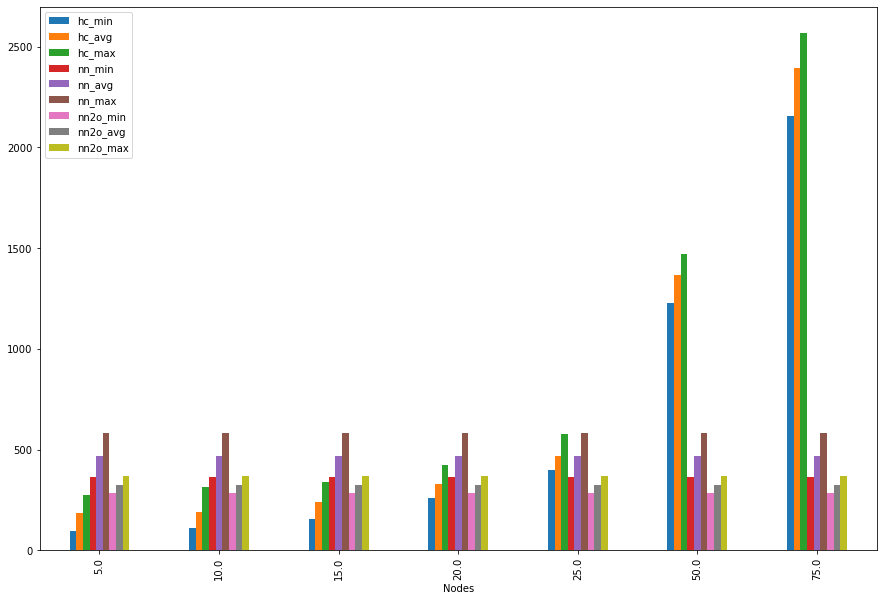

In [108]:
%matplotlib inline
data = np.array(exp5_stats)

columns = ['Nodes',
          'hc_min', 'hc_avg', 'hc_max',
          'nn_min', 'nn_avg', 'nn_max',
          'nn2o_min', 'nn2o_avg', 'nn2o_max',
          ]

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(15,10))
plt.show()

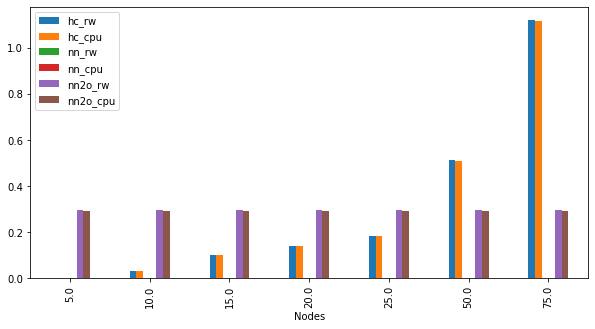

In [110]:
%matplotlib inline
data = np.array(exp5_runtimes)

columns = ['Nodes',
          'hc_rw', 'hc_cpu',
          'nn_rw', 'nn_cpu',
          'nn2o_rw', 'nn2o_cpu',
          ]

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(10,5))
plt.show()

Comparing the given graphs we can see that Hill-climbing (with given parameters) starts performing terribly bad at higher dimensions, due to the fact that the space of possible solutions gets really big, and so it easy for it to get stuck into a bad local minimum. It also becomes ineffective regarding the computation time. 

However, it is a good and fast approach for smaller graphs, and it can outperform A* in some cases as well.

Now let's see how number of restarts affect the solution.

In [112]:
dims = [5, 10, 15, 20, 25, 50]
exp6_stats = []
exp6_runtimes = []
for i, dim in enumerate(dims):
    print('dim:', dim)
    print('-------------------------------')
    stats = [dim]
    runtimes = [dim]
    tsp_matrices = matrix_families[i]
    nn2o_exp6 = compute_and_time_it(tsp_matrices, A_NN2O)
    print('NN2O:')
    stats.append(calc_stats(nn2o_exp6[0])[1])
    runtimes.extend(nn2o_exp6[1:])
    print('\n')
    
    for n in [50, 100, 250, 500, 750]:
        print('num_restarts =', n)
        hc_exp6 = compute_and_time_it(tsp_matrices, partial(hill_climbing, 
                                                            num_restarts=n))
        print('Hill-climbing:',)
        stats.append(calc_stats(hc_exp6[0])[1])
        runtimes.extend(hc_exp6[1:])
        print('------------------------------')
    exp6_stats.append(stats)
    exp6_runtimes.append(runtimes)
    print('------------------------------')

dim: 5
-------------------------------
Total real-world running time: 0.0002min
Total CPU running time: 0.0min
NN2O:
MIN: 97, AVG: 185.73, MAX: 277


num_restarts = 50
Total real-world running time: 0.0013min
Total CPU running time: 0.0018min
Hill-climbing:
MIN: 97, AVG: 184.83, MAX: 273
------------------------------
num_restarts = 100
Total real-world running time: 0.0024min
Total CPU running time: 0.0023min
Hill-climbing:
MIN: 97, AVG: 184.83, MAX: 273
------------------------------
num_restarts = 250
Total real-world running time: 0.0057min
Total CPU running time: 0.0055min
Hill-climbing:
MIN: 97, AVG: 184.83, MAX: 273
------------------------------
num_restarts = 500
Total real-world running time: 0.0119min
Total CPU running time: 0.0117min
Hill-climbing:
MIN: 97, AVG: 184.83, MAX: 273
------------------------------
num_restarts = 750
Total real-world running time: 0.0175min
Total CPU running time: 0.0169min
Hill-climbing:
MIN: 97, AVG: 184.83, MAX: 273
---------------------------

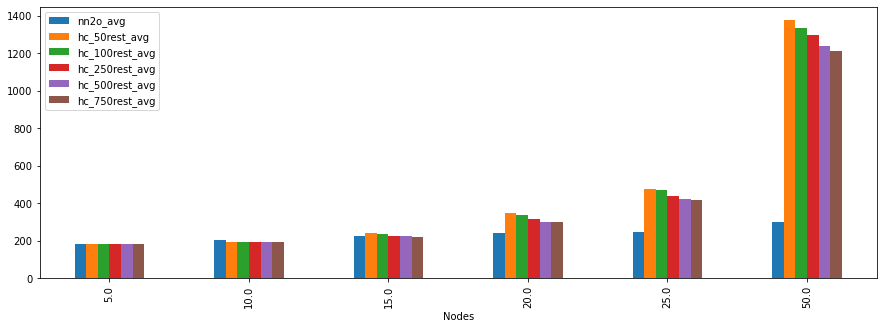

In [114]:
%matplotlib inline
data = np.array(exp6_stats)

columns = ['Nodes', 'nn2o_avg', 'hc_50rest_avg', 'hc_100rest_avg', 'hc_250rest_avg',
           'hc_500rest_avg', 'hc_750rest_avg']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(15, 5))
plt.show()

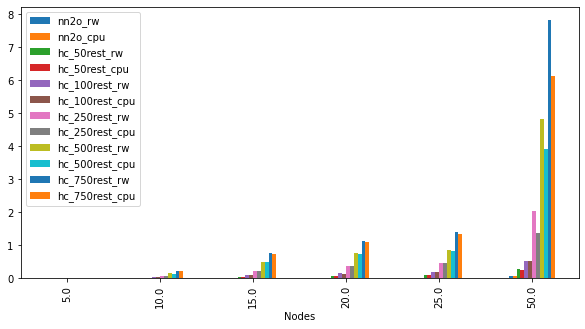

In [115]:
%matplotlib inline
data = np.array(exp6_runtimes)

columns = ['Nodes',
          'nn2o_rw', 'nn2o_cpu',
          'hc_50rest_rw', 'hc_50rest_cpu',
          'hc_100rest_rw', 'hc_100rest_cpu',
          'hc_250rest_rw', 'hc_250rest_cpu',
          'hc_500rest_rw', 'hc_500rest_cpu',
          'hc_750rest_rw', 'hc_750rest_cpu']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(10,5))
plt.show()

We'll also check will changing the maximal number of iterations can improve the solution.

In [117]:
dims = [5, 10, 15, 20, 25, 50]
exp7_stats = []
exp7_runtimes = []
for i, dim in enumerate(dims):
    print('dim:', dim)
    print('-------------------------------')
    stats = [dim]
    runtimes = [dim]
    tsp_matrices = matrix_families[i]
    nn2o_exp7 = compute_and_time_it(tsp_matrices, A_NN2O)
    print('NN2O:')
    stats.append(calc_stats(nn2o_exp7[0])[1])
    runtimes.extend(nn2o_exp7[1:])
    print('\n')
    
    for i in [50, 100, 250, 500, 750]:
        print('max_iter =', i)
        hc_exp7 = compute_and_time_it(tsp_matrices, partial(hill_climbing, 
                                                           max_iter=i))
        print('Hill-climbing:',)
        stats.append(calc_stats(hc_exp7[0])[1])
        runtimes.extend(hc_exp7[1:])
        print('------------------------------')
    exp7_stats.append(stats)
    exp7_runtimes.append(runtimes)
    print('------------------------------')

dim: 5
-------------------------------
Total real-world running time: 0.0002min
Total CPU running time: 0.0003min
NN2O:
MIN: 97, AVG: 185.73, MAX: 277


max_iter = 50
Total real-world running time: 0.0034min
Total CPU running time: 0.0034min
Hill-climbing:
MIN: 97, AVG: 184.83, MAX: 273
------------------------------
max_iter = 100
Total real-world running time: 0.0031min
Total CPU running time: 0.0031min
Hill-climbing:
MIN: 97, AVG: 184.83, MAX: 273
------------------------------
max_iter = 250
Total real-world running time: 0.0031min
Total CPU running time: 0.0029min
Hill-climbing:
MIN: 97, AVG: 184.83, MAX: 273
------------------------------
max_iter = 500
Total real-world running time: 0.0034min
Total CPU running time: 0.0034min
Hill-climbing:
MIN: 97, AVG: 184.83, MAX: 273
------------------------------
max_iter = 750
Total real-world running time: 0.0031min
Total CPU running time: 0.0031min
Hill-climbing:
MIN: 97, AVG: 184.83, MAX: 273
------------------------------
-------------

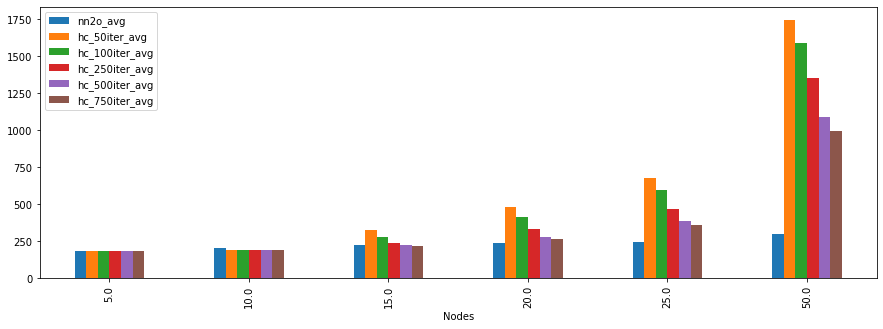

In [118]:
%matplotlib inline
data = np.array(exp7_stats)

columns = ['Nodes', 'nn2o_avg', 'hc_50iter_avg', 'hc_100iter_avg', 'hc_250iter_avg',
           'hc_500iter_avg', 'hc_750iter_avg']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(15, 5))
plt.show()

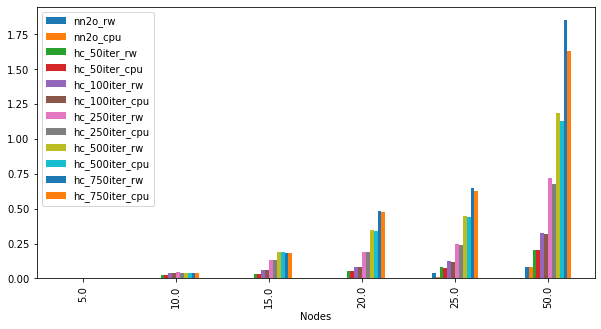

In [119]:
%matplotlib inline
data = np.array(exp7_runtimes)

columns = ['Nodes',
          'nn2o_rw', 'nn2o_cpu',
          'hc_50iter_rw', 'hc_50iter_cpu',
          'hc_100iter_rw', 'hc_100iter_cpu',
          'hc_250iter_rw', 'hc_250iter_cpu',
          'hc_500iter_rw', 'hc_500iter_cpu',
          'hc_750iter_rw', 'hc_750iter_cpu']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(10,5))
plt.show()

### Simmulated Annealing algorithm

We perform a series of experiments with Simmulated Annealing algorithm, while varying parameters such is number of restarts, cooling ratio, initial temperature.

In [120]:
def prob(new_cost, best_cost, t):
    
    '''Probability function for accepting the new state.'''
    
    if new_cost < best_cost:
        return 1
    else:
        return np.exp(-(new_cost - best_cost)/(dim*t))

In [125]:
def sim_annealing(A, num_restarts=100, init_temp=1000, cooling=.25):
    
    overall_best_route = None
    overall_best_cost = np.inf
    
    for _ in range(num_restarts):
        temperature = init_temp
        best_route = list(range(1, dim))
        random.shuffle(best_route)
        best_route = [0] + best_route + [0]
        best_cost = calc_total_cost(A, best_route)
        
        while temperature > 1e-10:
            node_combinations = [(a, b) for a in best_route[1:-1] for b in best_route[1:-1] if a < b]
            for two_nodes in node_combinations:
                new_route = node_swap(best_route.copy(), two_nodes)
                new_cost = calc_total_cost(A, new_route)
                temperature = temperature*cooling
                
                p = prob(new_cost, best_cost, temperature)
                if p  > random.random():
                    best_route = new_route
                    best_cost = new_cost
                    break

                if temperature <= 1e-10:
                    break
            
    if best_cost < overall_best_cost:
        overall_best_route = best_route
        overall_best_cost = best_cost
        
    return overall_best_route, overall_best_cost

In [129]:
dims = [5, 10, 15, 20, 25, 50, 75]
exp8_stats = []
exp8_runtimes = []
for i, dim in enumerate(dims):
    print('dim:', dim)
    print('-------------------------------')
    stats = [dim]
    runtimes = [dim]
    tsp_matrices = matrix_families[i]
    
    print('Smmulated-annealing:')
    sima = compute_and_time_it(tsp_matrices, sim_annealing)
    stats.extend(calc_stats(sima[0]))
    runtimes.extend(sima[1:])
    print('\n')
    
    print('NN:')
    stats.extend(calc_stats(nn[0]))
    runtimes.extend(nn[1:])
    print('\n')
    
    
    print('NN2O:')
    stats.extend(calc_stats(nn2o[0]))
    runtimes.extend(nn2o[1:])
    print('\n')
    
    
    exp8_stats.append(stats)
    exp8_runtimes.append(runtimes)
    print('-------------------------------')

dim: 5
-------------------------------
Smmulated-annealing:
Total real-world running time: 0.0112min
Total CPU running time: 0.0109min
MIN: 97, AVG: 188.67, MAX: 312


NN:
MIN: 365, AVG: 467.9, MAX: 584


NN2O:
MIN: 285, AVG: 325.27, MAX: 371


-------------------------------
dim: 10
-------------------------------
Smmulated-annealing:
Total real-world running time: 0.0159min
Total CPU running time: 0.0159min
MIN: 223, AVG: 365.17, MAX: 491


NN:
MIN: 365, AVG: 467.9, MAX: 584


NN2O:
MIN: 285, AVG: 325.27, MAX: 371


-------------------------------
dim: 15
-------------------------------
Smmulated-annealing:
Total real-world running time: 0.0257min
Total CPU running time: 0.0247min
MIN: 379, AVG: 607.1, MAX: 855


NN:
MIN: 365, AVG: 467.9, MAX: 584


NN2O:
MIN: 285, AVG: 325.27, MAX: 371


-------------------------------
dim: 20
-------------------------------
Smmulated-annealing:
Total real-world running time: 0.0352min
Total CPU running time: 0.0339min
MIN: 608, AVG: 843.4, MAX: 107

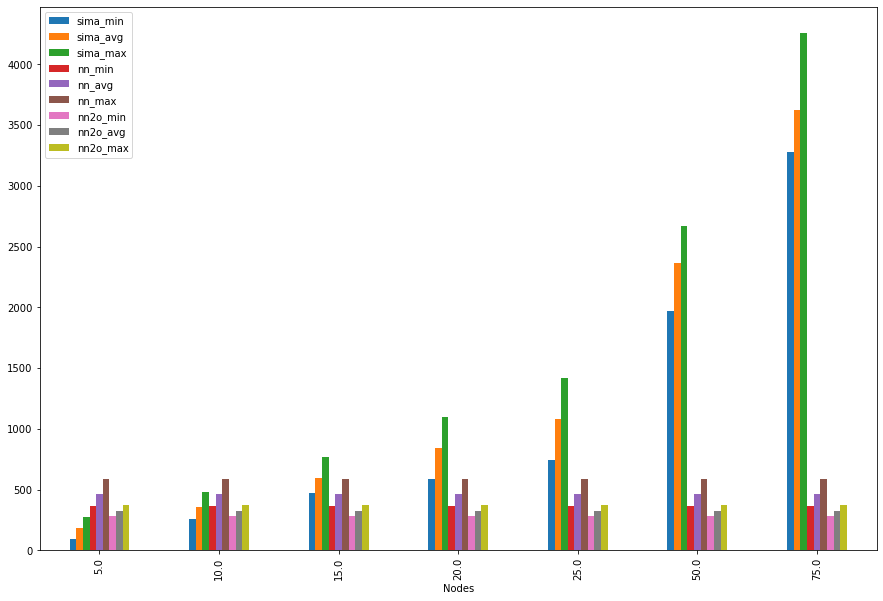

In [127]:
%matplotlib inline
data = np.array(exp8_stats)

columns = ['Nodes',
          'sima_min', 'sima_avg', 'sima_max',
          'nn_min', 'nn_avg', 'nn_max',
          'nn2o_min', 'nn2o_avg', 'nn2o_max',
          ]

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(15,10))
plt.show()

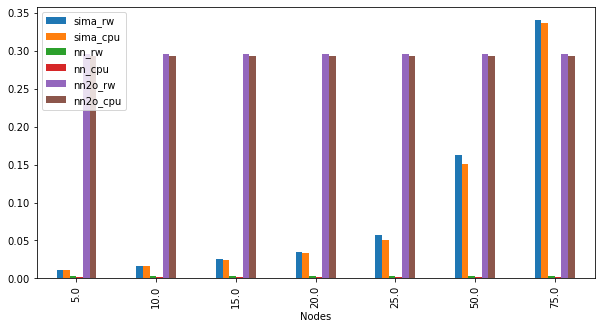

In [140]:
%matplotlib inline
data = np.array(exp8_runtimes)

columns = ['Nodes',
          'sima_rw', 'sima_cpu',
          'nn_rw', 'nn_cpu',
          'nn2o_rw', 'nn2o_cpu',
          ]

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(10,5))
plt.show()

In [131]:
dims = [5, 10, 15, 20, 25, 50]
exp9_stats = []
exp9_runtimes = []
for i, dim in enumerate(dims):
    print('dim:', dim)
    print('-------------------------------')
    stats = [dim]
    runtimes = [dim]
    tsp_matrices = matrix_families[i]
    nn2o_exp9 = compute_and_time_it(tsp_matrices, A_NN2O)
    print('NN2O:')
    stats.append(calc_stats(nn2o_exp9[0])[1])
    runtimes.extend(nn2o_exp9[1:])
    print('\n')
    
    for n in [50, 100, 250, 500, 750]:
        print('num_restarts =', n)
        sima_exp9 = compute_and_time_it(tsp_matrices, partial(sim_annealing, 
                                                            num_restarts=n))
        print('Simmulated Annealing:',)
        stats.append(calc_stats(sima_exp9[0])[1])
        runtimes.extend(sima_exp9[1:])
        print('------------------------------')
    exp9_stats.append(stats)
    exp9_runtimes.append(runtimes)
    print('------------------------------')

dim: 5
-------------------------------
Total real-world running time: 0.0002min
Total CPU running time: 0.0min
NN2O:
MIN: 97, AVG: 185.73, MAX: 277


num_restarts = 50
Total real-world running time: 0.0051min
Total CPU running time: 0.0052min
Simmulated Annealing:
MIN: 97, AVG: 190.77, MAX: 347
------------------------------
num_restarts = 100
Total real-world running time: 0.0101min
Total CPU running time: 0.0102min
Simmulated Annealing:
MIN: 97, AVG: 187.03, MAX: 277
------------------------------
num_restarts = 250
Total real-world running time: 0.0273min
Total CPU running time: 0.0268min
Simmulated Annealing:
MIN: 97, AVG: 187.23, MAX: 277
------------------------------
num_restarts = 500
Total real-world running time: 0.0589min
Total CPU running time: 0.0576min
Simmulated Annealing:
MIN: 97, AVG: 185.77, MAX: 277
------------------------------
num_restarts = 750
Total real-world running time: 0.0747min
Total CPU running time: 0.0742min
Simmulated Annealing:
MIN: 97, AVG: 187.03, M

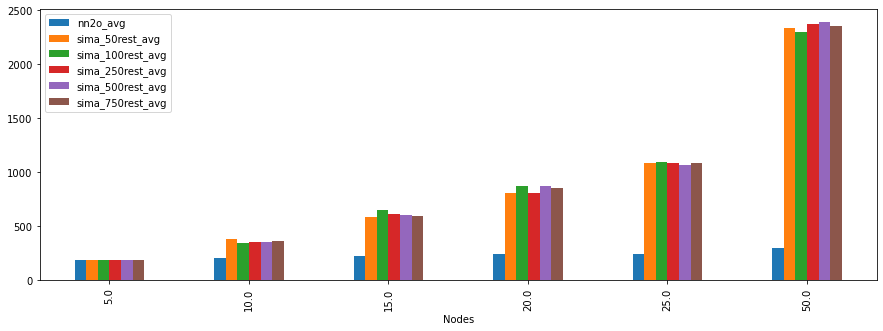

In [133]:
%matplotlib inline
data = np.array(exp9_stats)

columns = ['Nodes', 'nn2o_avg', 'sima_50rest_avg', 'sima_100rest_avg', 'sima_250rest_avg',
           'sima_500rest_avg', 'sima_750rest_avg']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(15, 5))
plt.show()

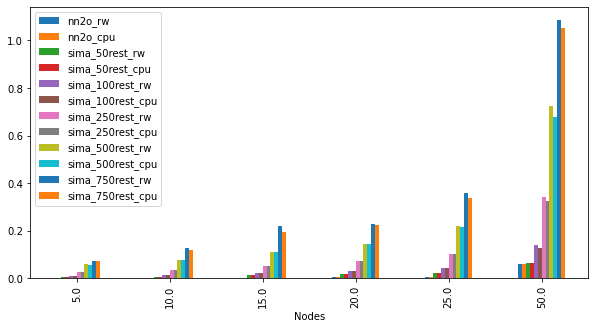

In [134]:
%matplotlib inline
data = np.array(exp9_runtimes)

columns = ['Nodes',
          'nn2o_rw', 'nn2o_cpu',
          'sima_50rest_rw', 'sima_50rest_cpu',
          'sima_100rest_rw', 'sima_100rest_cpu',
          'sima_250rest_rw', 'sima_250rest_cpu',
          'sima_500rest_rw', 'sima_500rest_cpu',
          'sima_750rest_rw', 'sima_750rest_cpu']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(10,5))
plt.show()

In [137]:
dims = [5, 10, 15, 20, 25, 50]
exp10_stats = []
exp10_runtimes = []
for i, dim in enumerate(dims):
    print('dim:', dim)
    print('-------------------------------')
    stats = [dim]
    runtimes = [dim]
    tsp_matrices = matrix_families[i]
    nn2o_exp10 = compute_and_time_it(tsp_matrices, A_NN2O)
    print('NN2O:')
    stats.append(calc_stats(nn2o_exp10[0])[1])
    runtimes.extend(nn2o_exp10[1:])
    print('\n')
    
    for cooling in [.5, .33, .25, .125, .1]:
        print('cooling =', cooling)
        sima_exp10 = compute_and_time_it(tsp_matrices, partial(sim_annealing, 
                                                            cooling=cooling))
        print('Simmulated Annealing:',)
        stats.append(calc_stats(sima_exp10[0])[1])
        runtimes.extend(sima_exp10[1:])
        print('------------------------------')
    exp10_stats.append(stats)
    exp10_runtimes.append(runtimes)
    print('------------------------------')

dim: 5
-------------------------------
Total real-world running time: 0.0002min
Total CPU running time: 0.0003min
NN2O:
MIN: 97, AVG: 185.73, MAX: 277


cooling = 0.5
Total real-world running time: 0.0215min
Total CPU running time: 0.0208min
Simmulated Annealing:
MIN: 97, AVG: 192.2, MAX: 347
------------------------------
cooling = 0.33
Total real-world running time: 0.0127min
Total CPU running time: 0.0128min
Simmulated Annealing:
MIN: 97, AVG: 192.0, MAX: 347
------------------------------
cooling = 0.25
Total real-world running time: 0.0109min
Total CPU running time: 0.0107min
Simmulated Annealing:
MIN: 97, AVG: 188.47, MAX: 312
------------------------------
cooling = 0.125
Total real-world running time: 0.0077min
Total CPU running time: 0.0076min
Simmulated Annealing:
MIN: 97, AVG: 188.47, MAX: 312
------------------------------
cooling = 0.1
Total real-world running time: 0.0069min
Total CPU running time: 0.0068min
Simmulated Annealing:
MIN: 97, AVG: 190.53, MAX: 347
-----------

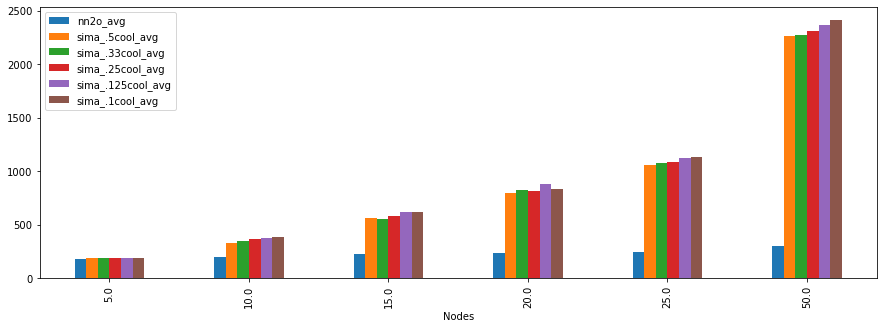

In [138]:
%matplotlib inline
data = np.array(exp10_stats)

columns = ['Nodes', 'nn2o_avg', 'sima_.5cool_avg', 'sima_.33cool_avg', 'sima_.25cool_avg',
           'sima_.125cool_avg', 'sima_.1cool_avg']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(15, 5))
plt.show()

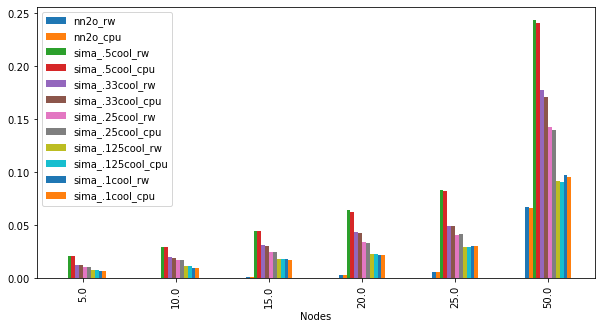

In [139]:
%matplotlib inline
data = np.array(exp10_runtimes)

columns = ['Nodes',
          'nn2o_rw', 'nn2o_cpu',
          'sima_.5cool_rw', 'sima_.5cool_cpu',
          'sima_.33cool_rw', 'sima_.33cool_cpu',
          'sima_.25cool_rw', 'sima_.25cool_cpu',
          'sima_.125cool_rw', 'sima_.125cool_cpu',
          'sima_.1cool_rw', 'sima_.1cool_cpu']

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(10,5))
plt.show()

In [143]:
dims = [5, 10, 15, 20, 25, 50]
exp11_stats = []
exp11_runtimes = []
for i, dim in enumerate(dims):
    print('dim:', dim)
    print('-------------------------------')
    stats = [dim]
    runtimes = [dim]
    tsp_matrices = matrix_families[i]
    nn2o_exp11 = compute_and_time_it(tsp_matrices, A_NN2O)
    print('NN2O:')
    stats.append(calc_stats(nn2o_exp11[0])[1])
    runtimes.extend(nn2o_exp11[1:])
    print('\n')
    
    for temp in [100, 1000, 10**4, 10**5]:
        print('initial temperature =', temp)
        sima_exp11 = compute_and_time_it(tsp_matrices, partial(sim_annealing, 
                                                            init_temp=temp))
        print('Simmulated Annealing:',)
        stats.append(calc_stats(sima_exp11[0])[1])
        runtimes.extend(sima_exp11[1:])
        print('------------------------------')
    exp11_stats.append(stats)
    exp11_runtimes.append(runtimes)
    print('------------------------------')

dim: 5
-------------------------------
Total real-world running time: 0.0002min
Total CPU running time: 0.0min
NN2O:
MIN: 97, AVG: 185.73, MAX: 277


initial temperature = 100
Total real-world running time: 0.0091min
Total CPU running time: 0.0094min
Simmulated Annealing:
MIN: 97, AVG: 192.2, MAX: 347
------------------------------
initial temperature = 1000
Total real-world running time: 0.0109min
Total CPU running time: 0.0109min
Simmulated Annealing:
MIN: 97, AVG: 187.9, MAX: 312
------------------------------
initial temperature = 10000
Total real-world running time: 0.0115min
Total CPU running time: 0.0112min
Simmulated Annealing:
MIN: 97, AVG: 186.47, MAX: 277
------------------------------
initial temperature = 100000
Total real-world running time: 0.0143min
Total CPU running time: 0.0143min
Simmulated Annealing:
MIN: 97, AVG: 186.87, MAX: 277
------------------------------
------------------------------
dim: 10
-------------------------------
Total real-world running time: 0.00

Although pretty fast overall and effective for smaller graphs, simmulated annealing didn't show good performance cost-wise, even with the parameter tuning.

### Genetic Algorithm

We use a genetic algorithm with alternating-position crossover and swap-nodes mutation.

In [144]:
def create_offspring(parent1, parent2):
    
    offspring = []
    for i in range(len(parent1)):
        if parent1[i] not in offspring:
            offspring.append(parent1[i])
        if parent2[i] not in offspring:
            offspring.append(parent2[i])
    return offspring

In [162]:
def gen_alg(A, max_iter=100, mutation_prob=0.05):
    
    population_pool = []
    for _ in range(20):
        init_route = list(range(1,dim))
        random.shuffle(init_route)
        population_pool.append(init_route)
        
    i = 0
    while i <= max_iter:
        parent1, parent2 = random.sample(population_pool, 2)
        offspring1 = create_offspring(parent1, parent2)
        offspring2 = create_offspring(parent2, parent1)
        population_pool += [offspring1, offspring2]
        
        for individual in population_pool:
            if random.random() < mutation_prob:
                mutated_nodes = random.sample(list(range(dim-1)), 2)
                individual = node_swap(individual, mutated_nodes)
        
        population_costs = []
        for individual in population_pool:
            ind = [0] + individual + [0]
            ind_cost = calc_total_cost(A, ind)
            population_costs.append(ind_cost)
            
        wors_ind = np.max(population_costs)
        survival_rate = [1-(1/ind_cost)*.85 for ind_cost in population_costs]
        for k, individual in enumerate(population_pool):
            if survival_rate[k] < random.random():
                population_pool.remove(individual)
                
        i += 1
        
    population_costs = []
    final_population_pool = [[0] + individual + [0] for individual in population_pool]
    for individual in final_population_pool:
        ind_cost = calc_total_cost(A, individual)
        population_costs.append(ind_cost)
        
    best_ind = np.argmin(population_costs)
    return final_population_pool[best_ind], population_costs[best_ind]      

In [163]:
dims = [5, 10, 15, 20, 25, 50, 75]
exp12_stats = []
exp12_runtimes = []
for i, dim in enumerate(dims):
    print('dim:', dim)
    print('-------------------------------')
    stats = [dim]
    runtimes = [dim]
    tsp_matrices = matrix_families[i]
    
    print('Genetic Algorithm:')
    ga = compute_and_time_it(tsp_matrices, gen_alg)
    stats.extend(calc_stats(ga[0]))
    runtimes.extend(ga[1:])
    print('\n')
    
    print('NN:')
    stats.extend(calc_stats(nn[0]))
    runtimes.extend(nn[1:])
    print('\n')
    
    
    print('NN2O:')
    stats.extend(calc_stats(nn2o[0]))
    runtimes.extend(nn2o[1:])
    print('\n')
    
    
    exp12_stats.append(stats)
    exp12_runtimes.append(runtimes)
    print('-------------------------------')

dim: 5
-------------------------------
Genetic Algorithm:
Total real-world running time: 0.023min
Total CPU running time: 0.0232min
MIN: 97, AVG: 184.83, MAX: 273


NN:
MIN: 365, AVG: 467.9, MAX: 584


NN2O:
MIN: 285, AVG: 325.27, MAX: 371


-------------------------------
dim: 10
-------------------------------
Genetic Algorithm:
Total real-world running time: 0.0341min
Total CPU running time: 0.0336min
MIN: 179, AVG: 295.1, MAX: 389


NN:
MIN: 365, AVG: 467.9, MAX: 584


NN2O:
MIN: 285, AVG: 325.27, MAX: 371


-------------------------------
dim: 15
-------------------------------
Genetic Algorithm:
Total real-world running time: 0.0451min
Total CPU running time: 0.0448min
MIN: 378, AVG: 490.8, MAX: 632


NN:
MIN: 365, AVG: 467.9, MAX: 584


NN2O:
MIN: 285, AVG: 325.27, MAX: 371


-------------------------------
dim: 20
-------------------------------
Genetic Algorithm:
Total real-world running time: 0.0626min
Total CPU running time: 0.0612min
MIN: 576, AVG: 678.0, MAX: 794


NN:
MIN

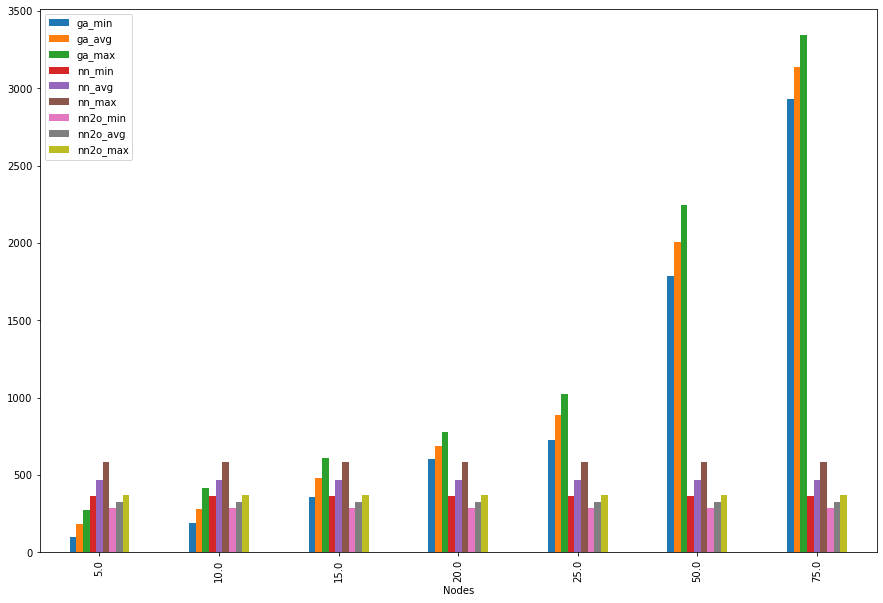

In [158]:
%matplotlib inline
data = np.array(exp12_stats)

columns = ['Nodes',
          'ga_min', 'ga_avg', 'ga_max',
          'nn_min', 'nn_avg', 'nn_max',
          'nn2o_min', 'nn2o_avg', 'nn2o_max',
          ]

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(15,10))
plt.show()

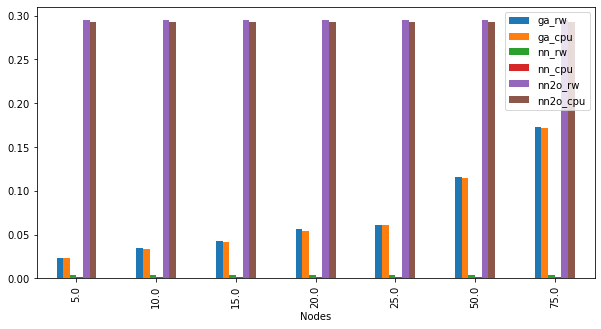

In [159]:
%matplotlib inline
data = np.array(exp12_runtimes)

columns = ['Nodes',
          'ga_rw', 'ga_cpu',
          'nn_rw', 'nn_cpu',
          'nn2o_rw', 'nn2o_cpu',
          ]

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(10,5))
plt.show()

The story's the same with the genetic algorihm - although it provides the fastest alternative to other algorithms in the local search family, and is cost-effective for smaller graphs, it starts breaking at higher dimensions.

### Comparison with A*

Finally, we compare A* with MST heuristic with local search algorithms.

In [164]:
dims = [5, 10, 15]
exp13_stats = []
exp13_runtimes = []
for i, dim in enumerate(dims):
    print('dim:', dim)
    print('-------------------------------')
    stats = [dim]
    runtimes = [dim]
    tsp_matrices = matrix_families[i]
    
    print('A*:')
    a_star = compute_and_time_it(tsp_matrices, A_star)
    stats.extend(calc_stats(a_star[0]))
    runtimes.extend(a_star[1:])
    print('\n')
    
    
    print('Genetic Algorithm:')
    ga = compute_and_time_it(tsp_matrices, gen_alg)
    stats.extend(calc_stats(ga[0]))
    runtimes.extend(ga[1:])
    print('\n')
    
    print('Simulated Annealing:')
    sima = compute_and_time_it(tsp_matrices, sim_annealing)
    stats.extend(calc_stats(sima[0]))
    runtimes.extend(sima[1:])
    print('\n')
    
    
    print('Hill-Climbing:')
    hc = compute_and_time_it(tsp_matrices, hill_climbing)
    stats.extend(calc_stats(hc[0]))
    runtimes.extend(hc[1:])
    print('\n')
    
    
    exp13_stats.append(stats)
    exp13_runtimes.append(runtimes)
    print('-------------------------------')

dim: 5
-------------------------------
A*:
Total real-world running time: 0.003min
Total CPU running time: 0.0029min
MIN: 16, AVG: 159.27, MAX: 265


Genetic Algorithm:
Total real-world running time: 0.0232min
Total CPU running time: 0.0229min
MIN: 97, AVG: 184.83, MAX: 273


Simulated Annealing:
Total real-world running time: 0.0106min
Total CPU running time: 0.0104min
MIN: 97, AVG: 188.3, MAX: 312


Hill-Climbing:
Total real-world running time: 0.0025min
Total CPU running time: 0.0026min
MIN: 97, AVG: 184.83, MAX: 273


-------------------------------
dim: 10
-------------------------------
A*:
Total real-world running time: 0.0262min
Total CPU running time: 0.0258min
MIN: 111, AVG: 215.3, MAX: 324


Genetic Algorithm:
Total real-world running time: 0.0344min
Total CPU running time: 0.0339min
MIN: 166, AVG: 293.73, MAX: 412


Simulated Annealing:
Total real-world running time: 0.0136min
Total CPU running time: 0.0138min
MIN: 207, AVG: 344.77, MAX: 461


Hill-Climbing:
Total real-worl

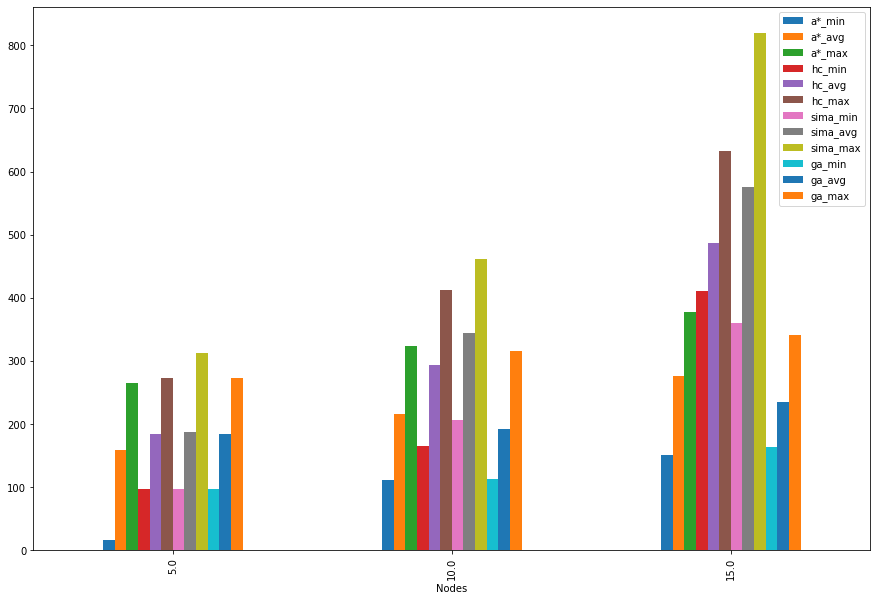

In [165]:
%matplotlib inline
data = np.array(exp13_stats)

columns = ['Nodes',
          'a*_min', 'a*_avg', 'a*_max',
          'hc_min', 'hc_avg', 'hc_max',
          'sima_min', 'sima_avg', 'sima_max',
          'ga_min', 'ga_avg', 'ga_max',
          ]

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(15,10))
plt.show()

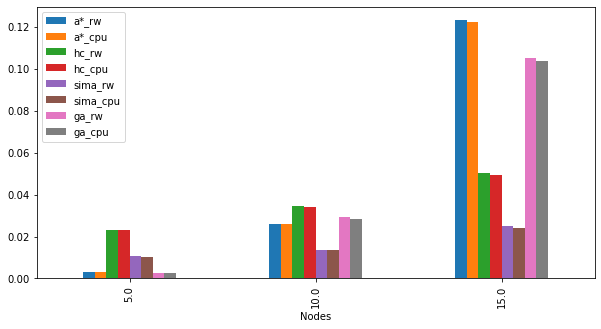

In [166]:
%matplotlib inline
data = np.array(exp13_runtimes)

columns = ['Nodes',
          'a*_rw', 'a*_cpu',
          'hc_rw', 'hc_cpu',
          'sima_rw', 'sima_cpu',
          'ga_rw', 'ga_cpu',
          ]

df = pd.DataFrame(data, columns=columns)
df.plot(x='Nodes', y=columns[1:], kind="bar", figsize=(10,5))
plt.show()

## Final Conclusion

Observing the last two graphs, we can conclude that for smaller dimensions, and a little bit of patience, we should definitely use A* with MST heuristic. But if we want our solution computed really fast, then using local search algorithms on smaller dimension can be also a good choice, especially if we are ready to tweak their parameters.

As for the higher dimensions, NN based algorithms from the Part 1 provide the best cost-running time tradeoff.